In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import LabelBinarizer

from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines, pipeline_Richard, pipeline_Julian
from pipelines import categorical_input_columns

RANDOM_STATE = 1234

In [6]:
# allele_columns = ["T0: Allele \nFraction", "T1: Allele Fraction"]
# load_process_and_store_spreadsheets(allele_columns=allele_columns, transformation=lambda x, y: y*x/(x+y))
load_process_and_store_spreadsheets()

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Classification

In [4]:
y_train_resp = y_train["response_grouped"]
y_test_resp = y_test["response_grouped"]

In [5]:
ps_class = build_classifier_pipelines()

We want to predict non-responders:

In [6]:
response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
pos_label = 'non responder (sd+pd)'

In [7]:
F1 = lambda x, y: f1_score(x, y, labels=response_labels, pos_label=pos_label)

In [8]:
from catboost import CatBoostClassifier
params = {
    'iterations': 400,
    'random_seed': RANDOM_STATE,
    'custom_loss': ['Precision', 'AUC', 'Accuracy', 'F1', 'Recall'],
    'eval_metric': 'F1',
    'logging_level': 'Silent',
}
cat = CatBoostClassifier(**params)

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [10]:
categorical_feature_indices = [X_train.columns.get_loc(column) for column in categorical_input_columns]

In [11]:
# cat.fit(
#     X_train, y_train_resp,
#     cat_features=categorical_feature_indices,
#     plot=True,
#     eval_set=(X_test, y_test_resp),
# )

## Architecure pipeline

In [12]:
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=F1,
)
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.766667,0.622222,0.760000,0.793651
RandomForestClassifier,0.838710,0.692308,0.736842,0.848485
GaussianNB,0.228571,0.843750,0.450000,0.843750
GradientBoostingClassifier,0.830769,0.830769,0.848485,0.865672
KNeighborsClassifier,0.852459,0.786885,0.827586,0.865672
LogisticRegression,0.842105,0.000000,0.842105,0.842105
SVC,0.865672,0.848485,0.865672,0.865672
DummyClassifier,0.865672,0.865672,0.865672,0.865672


In [13]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    0.761328
Julian_test     0.686261
Freeman_test    0.774545
Lev_test        0.848835
dtype: float64
--------------------
DecisionTreeClassifier        0.735635
RandomForestClassifier        0.779086
GaussianNB                    0.591518
GradientBoostingClassifier    0.843924
KNeighborsClassifier          0.833151
LogisticRegression            0.631579
SVC                           0.861375
DummyClassifier               0.865672
dtype: float64


In [34]:
p_win = ps_class['DummyClassifier']['Julian']

The confusion matrix $M_{ij}$: predicted $i$ but truth is $j$.

Confusion matrix, without normalization
[[29  0]
 [ 9  0]]


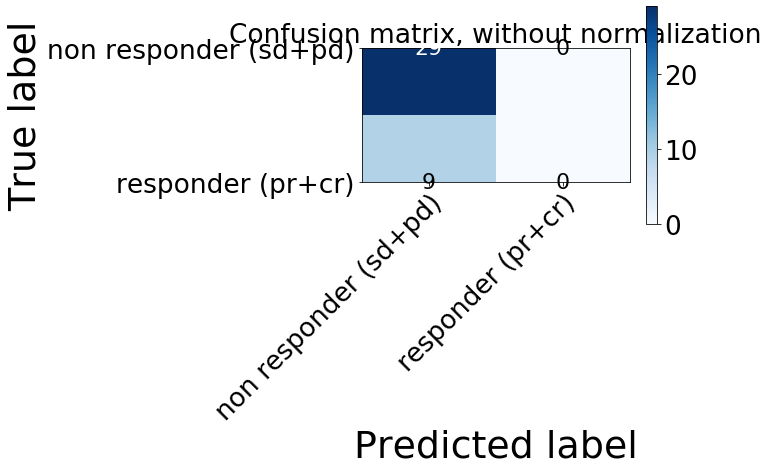

In [35]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=response_labels)

Precision:
$$p = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}$$

Recall or sensitivity:
$$r = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$$

In [16]:
r = lambda x,y: recall_score(x, y, labels=response_labels, pos_label=pos_label)
p = lambda x, y: precision_score(x, y, labels=response_labels, pos_label=pos_label)
recall = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=r,
)
recall

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.793103,0.482759,0.655172,0.862069
RandomForestClassifier,0.896552,0.620690,0.724138,0.965517
GaussianNB,0.137931,0.931034,0.310345,0.931034
GradientBoostingClassifier,0.931034,0.931034,0.965517,1.000000
KNeighborsClassifier,0.896552,0.827586,0.827586,1.000000
LogisticRegression,0.827586,0.000000,0.827586,0.827586
SVC,1.000000,0.965517,1.000000,1.000000
DummyClassifier,1.000000,1.000000,1.000000,1.000000


In [17]:
precision = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=p,
)
precision

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.741935,0.875000,0.904762,0.735294
RandomForestClassifier,0.787879,0.782609,0.750000,0.756757
GaussianNB,0.666667,0.771429,0.818182,0.771429
GradientBoostingClassifier,0.750000,0.750000,0.756757,0.763158
KNeighborsClassifier,0.812500,0.750000,0.827586,0.763158
LogisticRegression,0.857143,0.000000,0.857143,0.857143
SVC,0.763158,0.756757,0.763158,0.763158
DummyClassifier,0.763158,0.763158,0.763158,0.763158


Confusion matrix, without normalization
[[ 5  4]
 [ 5 24]]


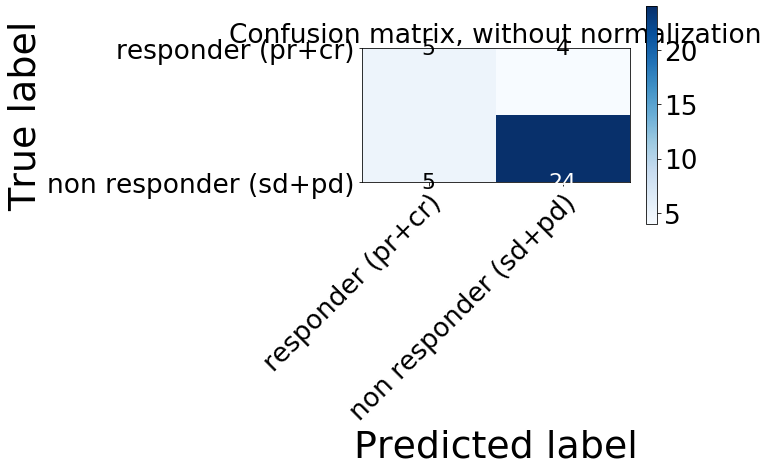

In [18]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, ps_class['LogisticRegression']['Lev'].predict(X_test), classes=y_test_resp.unique())

## Dimensional representation

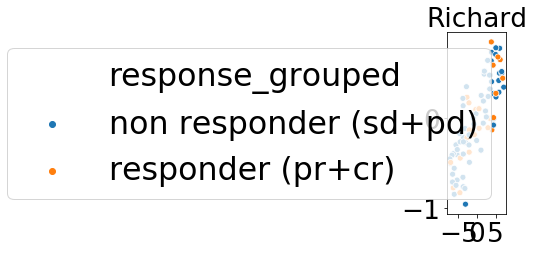

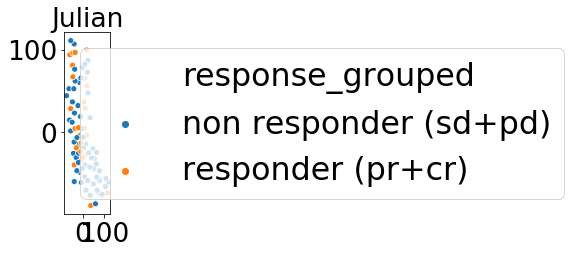

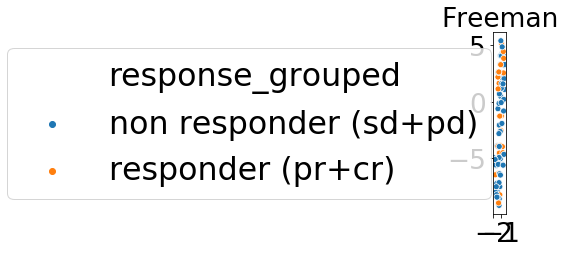

In [19]:
from views import view_pipelines

view_pipelines(ps_class['LogisticRegression'], X_train, y_train_resp, random_state=RANDOM_STATE)

## Regression

In [20]:
y_train_os = y_train['OS_days']
y_test_os = y_test['OS_days']
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']

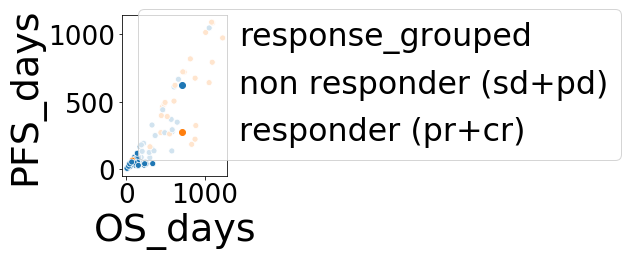

In [21]:
sns.scatterplot(x=y_train_os, y=y_train_pfs, hue=y_train_resp)

### Overall survival (OS)

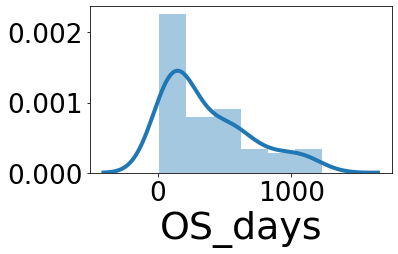

In [22]:
sns.distplot(y_train_os, norm_hist=False)

In [23]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_os, X_test, y_test_os, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [24]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test     316.799757
Julian_test      273.822018
Freeman_test    2549.116151
Lev_test         286.744276
dtype: float64
--------------------
DecisionTreeRegressor         326.059441
RandomForestRegressor         296.955987
GradientBoostingRegressor     289.663396
KNeighborsRegressor           329.864993
ElasticNet                    270.800778
LinearRegression             4785.434524
SVR                           277.112477
DummyRegressor                277.072810
dtype: float64


In [25]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,376.021202,281.671424,338.898153,307.646985
RandomForestRegressor,343.277793,254.163290,300.835392,289.547471
GradientBoostingRegressor,316.987848,265.141758,293.543479,282.980501
KNeighborsRegressor,369.776634,277.972411,360.920693,310.790233
ElasticNet,271.507413,271.719567,271.507413,268.468716
LinearRegression,302.710133,285.608105,18273.106791,280.313067
SVR,277.044226,277.226783,277.044475,277.134425
DummyRegressor,277.072810,277.072810,277.072810,277.072810


## Progression Free Survival (PFS)

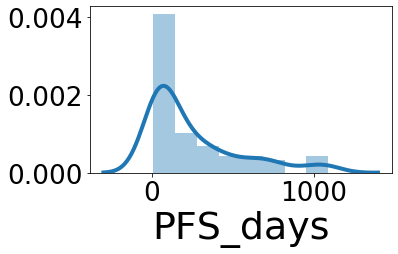

In [26]:
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']
sns.distplot(y_train_pfs)

In [27]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_pfs, X_test, y_test_pfs, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [28]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test     311.473587
Julian_test      291.781424
Freeman_test    1051.707342
Lev_test         292.314766
dtype: float64
--------------------
DecisionTreeRegressor         309.096807
RandomForestRegressor         284.806909
GradientBoostingRegressor     290.742694
KNeighborsRegressor           327.003045
ElasticNet                    278.727391
LinearRegression             1806.691293
SVR                           298.763554
DummyRegressor                298.722543
dtype: float64


In [29]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,361.213276,285.557968,292.754547,296.861438
RandomForestRegressor,291.047843,290.831514,277.033292,280.314987
GradientBoostingRegressor,307.619806,275.588794,293.512710,286.249468
KNeighborsRegressor,353.867007,298.275960,340.426503,315.442709
ElasticNet,273.793199,288.651318,273.771560,278.693487
LinearRegression,306.814569,297.770898,6338.727205,283.452499
SVR,298.710452,298.852397,298.710374,298.780994
DummyRegressor,298.722543,298.722543,298.722543,298.722543


## Multitask model


In [30]:
from sklearn.linear_model import MultiTaskElasticNet
from pipelines import pipelines
ps = pipelines(MultiTaskElasticNet, VotingEstimator=None)

In [31]:
Y_train = y_train[['OS_days', 'PFS_days']]
Y_test = y_test[['OS_days', 'PFS_days']]
rmse = lambda a, b: mean_squared_error(a, b, multioutput='raw_values')**0.5
benchmark_pipelines({'bla': ps}, X_train, Y_train, X_test, Y_test, metric=rmse)
# p = ps['Richard']
# p.fit(X_train, Y_train)

,Freeman_test,Julian_test,Richard_test
bla,"[268.39201279796964, 273.6714751582935]","[271.71276654564804, 288.65935292136504]","[268.40506641346275, 273.6944998454938]"
